In [2]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyrOpt//"
import numpy as np
import matplotlib.pyplot as plt
save_dir = "C://Users//User//Desktop//pcoop_plots//"
import time
import os
import matplotlib.colors as mcolors
from numba import jit
import os
# os.environ['OMP_NUM_THREADS'] = '1'  # set the value to 4

In [3]:
def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = ""
    if surf_idx:
        out_str += "2n-trans//"
    else:
        out_str += "2n-cis//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str

surf_labels = ["cis", "trans"]
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "-1.5V", "-1.2V","-0.9V", "-0.6V"]

def gen_dirname(lookat1, lookat2, surf_idx, save_dir):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel
    out_str += lookat1.split(' #')[0]
    out_str += lookat1.split(' #')[1]
    out_str += '-'
    out_str += lookat2.split(' #')[0]
    out_str += lookat2.split(' #')[1]
    out_str += '//'
    return out_str

def lb_idx(Emin, dE, sample):
    a = sample-Emin
    b = a/dE
    c = int(np.floor(b))
    return c, abs(b-c)

def lsstr(atom_label):
    saveable_string = ""
    use = atom_label.split(" #")
    for u in use:
        saveable_string += u
    return saveable_string

@jit(nopython=True)
def get_overlap_matrix(proj, wk, orbs_sample, nk, nj, out):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    out[i, j] += abs(t1_conj * t2) * abs(wk[ik])
    return out

def system_atomwise_pcoop_matrix_all(surf_idx, bias_idx):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    # T_juk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E)
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    pcoops_list = get_overlap_matrix(np.array(proj, dtype=np.complex128), np.array(wk), np.array(orbs_sample, dtype=int), nk, nj, np.zeros([len(orbs_sample), len(orbs_sample)], dtype=np.complex128))
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, mu, orbs_dict.keys()

@jit(nopython=True)
def get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    nrange = 10
    for i in range(nrange):
        act = idx + i - int(np.floor(nrange/2.))
        outij[act] += height*np.exp(-((Erange[act] - ejk)**2)/(4*dE))


@jit(nopython=True)
def get_overlap_matrix_plottable_smear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, out[i,j], dE)
    return out


#@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    spill = abs(b-idx)
    outij[idx] += height*(1 - spill)
    outij[idx+1] += height*spill

#@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, out[i,j], dE)
    return out

def system_atomwise_pcoop_matrix_all_plottable(surf_idx, bias_idx, dosmear=True):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    Emin = np.min(E)
    Emax = np.max(E)
    dE = 0.01
    Emax, Emin = cfunc.adjust_Ebounds(Emin, Emax, dE)
    Erange = np.arange(Emin, Emax, dE)
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    if dosmear:
        pcoops_list = get_overlap_matrix_plottable_smear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    else:
        pcoops_list = get_overlap_matrix_plottable_nosmear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, Erange, mu, orbs_dict.keys()

datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all_plottable(sidx, bidx))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

1/18: 10.852774143218994 seconds.
avg: 10.852774143218994
2/18: 9.172072172164917 seconds.
avg: 10.012423157691956
3/18: 9.772607326507568 seconds.
avg: 9.93248454729716
4/18: 9.501961946487427 seconds.
avg: 9.824853897094727
5/18: 9.457016944885254 seconds.
avg: 9.751286506652832
6/18: 9.454300165176392 seconds.
avg: 9.701788783073425
7/18: 9.203687906265259 seconds.
avg: 9.630631514957972
8/18: 9.451020002365112 seconds.
avg: 9.608180075883865
9/18: 9.525305032730103 seconds.
avg: 9.598971737755669
10/18: 9.48317813873291 seconds.
avg: 9.587392377853394
11/18: 9.664438247680664 seconds.
avg: 9.594396547837691
12/18: 9.603840827941895 seconds.
avg: 9.595183571179708
13/18: 9.200662851333618 seconds.
avg: 9.564835823499239
14/18: 9.603365182876587 seconds.
avg: 9.56758792059762
15/18: 9.303117752075195 seconds.
avg: 9.54995657602946
16/18: 9.411011695861816 seconds.
avg: 9.541272521018982
17/18: 9.178774118423462 seconds.
avg: 9.519949085572186
18/18: 9.626079559326172 seconds.
avg: 9.

In [109]:
from sklearn.mixture import GaussianMixture

@jit(nopython=True)
def _smooth(y, nsamples, out):
    for i in range(1, nsamples-1):
        out[i] += np.average(y[i-1:i+2])
    out[0] += y[0]
    out[-1] += y[-1]
    return out

def smooth(y, loops = 1, _loop_cur = 0):
    nsamples = len(y)
    if _loop_cur < loops:
        out = np.zeros(nsamples)
        out = _smooth(y, nsamples, out)
        return smooth(out, loops = loops, _loop_cur = _loop_cur + 1)
    else:
        return y


def gaussfit(xx, y, n_gaussians, max_iter = 100, n_init = 1, tol  = 1e-3):
    y_normalized = y / y.sum()
    x_sample = np.repeat(xx, (y_normalized * 5000).astype(int))
    X = x_sample[:, np.newaxis]
    gmm = GaussianMixture(n_components=n_gaussians, max_iter=max_iter, tol=tol, n_init = n_init)
    gmm.fit(X)
    return gmm

def get_each_gaus(gmm, xrange):
    ngaus = len(gmm.weights_)
    yys = []
    for i in range(ngaus):
        yys.append(get_gaus_i(gmm, xrange, i))
    return yys


def get_gaus_i(gmm, xrange, i):
    weight_i = gmm.weights_[i]
    # covariances_ is a (n, 1, 1) array for some reason, thus the [0][0] is needed
    sq_cov_i = np.sqrt(gmm.covariances_[i][0][0])
    # means is a (n, 1) array for some reason, thus the [0] is needed
    means_i = gmm.means_[i][0]
    prefac = weight_i/sq_cov_i
    out = np.exp(-(1/2)*(
            (xrange - means_i)/(sq_cov_i)
    )**2)
    # Changed bc wierd output shape
    if len(np.shape(out)) > 1:
        return (prefac * out)[:, 0]
    else:
        return prefac * out

@jit(nopython=True)
def _get_dist_overlap(dist1, dist2, nsamples, _overlap = 0):
    for i in range(nsamples):
        _overlap += max(dist1[i], dist2[i]) * (min(dist1[i], dist2[i]) / max(dist1[i], dist2[i]))
    return _overlap

def get_dist_overlap(dist1, dist2, weight1, weight2):
    nsamples = len(dist1)
    _overlap = _get_dist_overlap(dist1, dist2, nsamples, _overlap = 0)
    return _overlap / (weight1 + weight2)

def get_overlap(gmm, xrange, i1, i2):
    dist1 = get_gaus_i(gmm, xrange, i1)
    dist2 = get_gaus_i(gmm, xrange, i2)
    weight1 = gmm.weights_[i1]
    weight2 = gmm.weights_[i2]
    return get_dist_overlap(dist1, dist2, weight1, weight2)

@jit(nopython=True)
def _find_closest_index(xval, xrange, _dist = 0.0, _best_dist = 1000.0, _idx = 0):
    for i in range(len(xrange)):
        _dist = xval - xrange[i]
        if _dist < 0:
            _dist *= -1
        if _dist < _best_dist:
            _best_dist = _dist
            _idx = i
    return _idx


def find_closest_index(xval, xrange):
    if len(np.shape(xrange)) > 1:
        xrange = xrange[:, 0]
    return _find_closest_index(xval, xrange)

@jit(nopython=True)
def _find_strattle_indices(xval, xrange, _best1 = 1000.0, _best2 = 1000.0, _idx1 = 0, _idx2 = 0, _dist = 0.0):
    for i in range(len(xrange)):
        _dist = xval - xrange[i]
        if _dist <= 0:
            _dist *= (-1.)
            if _dist < _best1:
                _best1 = _dist
                _idx1 = i
        else:
            if _dist < _best2:
                _best2 = _dist
                _idx2 = i
    return _idx1, _idx2

def find_strattle_indices(xval, xrange):
    if len(np.shape(xrange)) > 1:
        xrange = xrange[:, 0]
    return _find_strattle_indices(np.float64(xval), np.array(xrange, dtype=np.float64))

def recast_axis(xrange, xrange_old, y_old):
    assert(len(xrange_old) == len(y_old))
    ynew = np.zeros(len(xrange))
    interp = len(xrange) < len(xrange_old)
    if interp:
        for i in range(len(xrange)):
            ynew[i] += y_old[find_closest_index(xrange[i], xrange_old)]
    else:
        for i in range(len(xrange)):
            i1, i2 = find_strattle_indices(xrange[i], xrange_old)
            ynew[i] += (y_old[i1] + y_old[i2])/2.
    return ynew

@jit(nopython=True)
def get_distribution(yys, yy_sum_in):
    for yy in yys:
        yy_sum_in += yy
    return yy_sum_in

def get_score(xx, y, gmm):
    samples = 1000
    _yy_in=np.zeros(samples)
    xx_range = np.linspace(xx.min(), xx.max(), samples)[:, np.newaxis]
    yys = get_each_gaus(gmm, xx_range)
    yy = get_distribution(yys, _yy_in)
    y = recast_axis(xx_range, xx, y)
    shift = np.max(y)/np.max(yy)
    yy *= shift
    off = 0
    for i in range(samples):
        off += abs(yy[i] - y[i])
    return off/(samples*(y.max()-y.min()))

In [110]:
look = np.real(datum[0][0])
xx = look[1]
start = time.time()
y = smooth(np.real(look[0][2][2]), loops = 1)
end = time.time()
print(end - start)
gmm = gaussfit(xx, y, 5, tol=1e-5, n_init=10)

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\numpy\lib\type_check.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(val).real


0.20904755592346191


0.29208497424572594


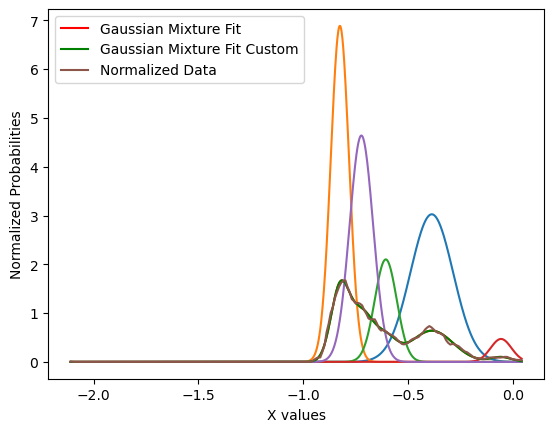

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'yys' of function 'get_distribution'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_2244\4199055367.py", line 121:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


0.007565778319919569


In [111]:
print(get_overlap(gmm, xx, 0, 1))

samples = 1000
ngaus = len(gmm.means_)
xx_range = np.linspace(xx.min(), xx.max(), samples)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))
yy_og = np.exp(-((xx_range - gmm.means_[0])/(np.sqrt(2*gmm.covariances_[0])))**2)
shift1 = np.max(y)/np.max(yy_gmm)
plt.plot(xx_range, yy_gmm*shift1, 'r-', label='Gaussian Mixture Fit')
yy_sum = np.zeros(len(xx_range))
for yy in get_each_gaus(gmm, xx_range):
    plt.plot(xx_range, yy)
    yy_sum += yy
shift2 = np.max(y)/np.max(yy_sum)
plt.plot(xx_range, yy_sum*shift2, 'g-', label='Gaussian Mixture Fit Custom')
plt.plot(look[1], y, label='Normalized Data')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()
print(get_score(xx,y, gmm))

In [115]:
def print_threshold_msg(score, score_thresh, _ite, ngaus):
    print("Iteration " + str(_ite + 1) + ": Score " + f"{score:.{3}g}" + "Above threshold of " + f"{score_thresh:.{3}g}")
    print("Increasing ngaus from " + str(ngaus) + " to " + str(ngaus+1))

def get_emin(means, covariances):
    minmean = min(means)
    covmin = covariances[list(means).index(minmean)]
    return minmean - (2*4.3*covmin)

def get_emax(means, covariances):
    maxmean = max(means)
    covmax = covariances[list(means).index(maxmean)]
    return maxmean + (20*covmax)

def construct_erange(means, covariances, weights, dE, Emin, Emax):
    if Emin is None:
        Emin = get_emin(means, covariances)
    if Emax is None:
        Emax = get_emax(means, covariances)
    if dE is None:
        dE = (Emax - Emin)/(100*len(means))
    return np.arange(Emin, Emax, dE)

def get_erange(means, covariances, weights, Erange, dE, Emin, Emax):
    if Erange is None:
        Erange = construct_erange(means, covariances, weights, dE, Emin, Emax)
    return Erange

def get_gaus_n(means, weights, covariances, Erange, i):
    prefac = weights[i]/np.sqrt(covariances[i])
    out = np.exp(-(1/2)*(
            (Erange - means[i])/np.sqrt(covariances[i])
    )**2)
    # Changed bc wierd output shape
    if len(np.shape(out)) > 1:
        return (prefac * out)[:, 0]
    else:
        return prefac * out

from scipy.interpolate import CubicSpline

def prepare(Es, Ys, dE = 0.01):
    spl = CubicSpline(Es, Ys)
    Erange = np.arange(np.min(Es), np.max(Es), dE)
    return Erange, spl(Erange)


def decompose(xrange, yrange, ngaus = 5, smooth_loops = 0, score_thresh = 0.1, _ite = 0, max_ite = 10):
    y = smooth(np.real(yrange), loops = smooth_loops)
    gmm = gaussfit(xrange, y, ngaus, tol=1e-5, n_init=ngaus*2)
    means = gmm.means_[:,0]
    covariances = gmm.covariances_[:,0,0]
    weights = gmm.weights_
    data = tuple([means, covariances, weights])
    score = get_score(xrange, yrange, gmm)
    if score > score_thresh:
        if _ite < max_ite:
            print_threshold_msg(score, score_thresh, _ite, ngaus)
            return decompose(xrange, yrange, ngaus = ngaus + 1, smooth_loops = smooth_loops, score_thresh = score_thresh, _ite = _ite + 1)
        else:
            return data, score
    return data, score

def reconstruct(decomp_data, Erange = None, dE = None, Emin = None, Emax = None):
    means = decomp_data[0]
    covariances = decomp_data[1]
    weights = decomp_data[2]
    Erange = get_erange(means, covariances, weights, Erange, dE, Emin, Emax)
    yrange = np.zeros(np.shape(Erange))
    for n in range(len(means)):
        yrange += get_gaus_n(means, weights, covariances, Erange, n)
    return Erange, yrange

In [127]:
data, score = decompose(np.real(look[1]),np.real(look[0][0][0]), ngaus=3, score_thresh=0.01, smooth_loops=0)

Iteration 1: Score 0.0403Above threshold of 0.01
Increasing ngaus from 3 to 4
Iteration 2: Score 0.0341Above threshold of 0.01
Increasing ngaus from 4 to 5
Iteration 3: Score 0.0168Above threshold of 0.01
Increasing ngaus from 5 to 6
Iteration 4: Score 0.0193Above threshold of 0.01
Increasing ngaus from 6 to 7
Iteration 5: Score 0.0134Above threshold of 0.01
Increasing ngaus from 7 to 8
Iteration 6: Score 0.0112Above threshold of 0.01
Increasing ngaus from 8 to 9
Iteration 7: Score 0.0105Above threshold of 0.01
Increasing ngaus from 9 to 10


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.838423427468302, -0.02819602088760309)

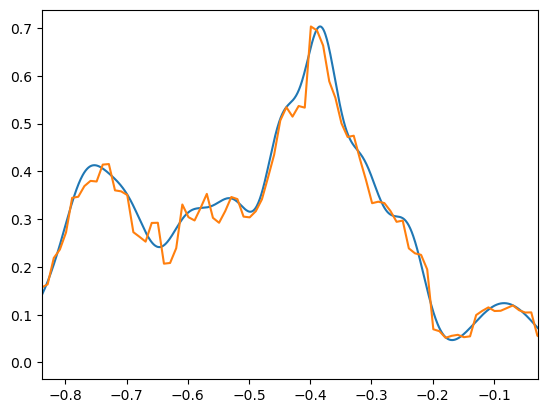

In [128]:
x, y = reconstruct(data)
plt.plot(x, y*(max(look[0][0][0])/max(y)))
plt.plot(look[1], look[0][0][0])
plt.xlim(min(x), max(x))